In [65]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
def f(x):
    return 3*x**2 - 4*x + 5

In [67]:
f(3.0)

20.0

In [68]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [69]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

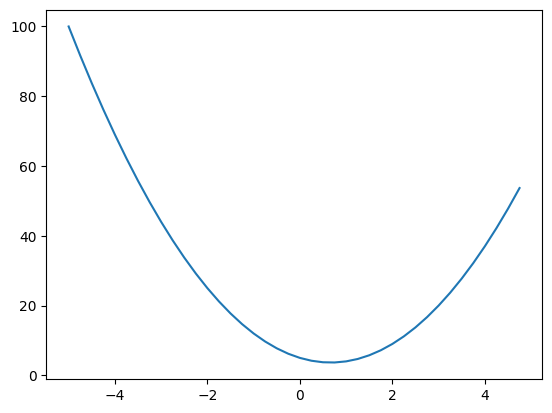

In [70]:
plt.plot(xs, ys)

In [71]:
h = 0.0000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [72]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [73]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
#a += h
#b += h
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 -d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [74]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
            
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    
#a = Value(2.0, label='a')
#a
#b = Value(-3.0, label='b')
#a.__add__(b)
#a + b
#c = Value(10.0, label='c')
#e = a*b; e.label ='e'
#d = a*b + c
#d = e + c; d.label ='d'
#f = Value(-2.0, label='f')
#d = a.__mul__(b).__add__(c)
#d
#L = d * f; L.label = 'L'
#L

In [75]:
#a = Value(2.0)
#b = Value(4.0)
#a / b
#a.exp()
#a - b

In [76]:
#d._prev

In [77]:
#d._op

In [78]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it 
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot  

In [79]:
#L.grad = 1.0
#f.grad = 4.0
#d.grad = -2.0
#c.grad = -2.0
#e.grad = -2.0
#a.grad = -2.0 * -3.0
#b.grad = -2.0 * 2.0

In [80]:
#draw_dot(L)

In [81]:
#a.data += 0.01 * a.grad
#b.data += 0.01 * b.grad
#c.data += 0.01 * c.grad
#f.data += 0.01 * f.grad

#e = a * b
#d = a + c
#L = d * f

#print(L.data)

In [82]:
#def lol():
    
#    h = 0.001
    
#    a = Value(2.0, label='a')
    #a
#    b = Value(-3.0, label='b')
    #a.__add__(b)
    #a + b
#    c = Value(10.0, label='c')
#    e = a*b; e.label ='e'
    #d = a*b + c
#    d = e + c; d.label ='d'
#    f = Value(-2.0, label='f')
    #d = a.__mul__(b).__add__(c)
    #d
#    L = d * f; L.label = 'L'
#    L1 = L.data
    
#    a = Value(2.0 , label='a')
    #a
    #a.data += h
#    b = Value(-3.0, label='b')
    #b.data += h
    #a.__add__(b)
    #a + b
#    c = Value(10.0, label='c')
    #c.data += h
#    e = a*b; e.label ='e'
    #e.data += h
    #d = a*b + c
#    d = e + c; d.label ='d'
#    d.data += h
#    f = Value(-2.0, label='f')
    #d = a.__mul__(b).__add__(c)
    #d
#    L = d * f; L.label = 'L'
#    L2 = L.data
    
#    print((L2 - L1)/h)
    
#lol()

In [83]:
#plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [84]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2' 
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

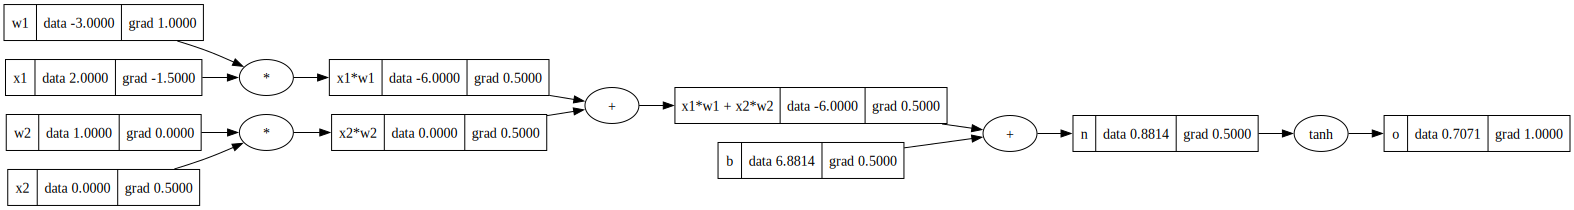

In [85]:
draw_dot(o)

In [86]:
#o.backward()

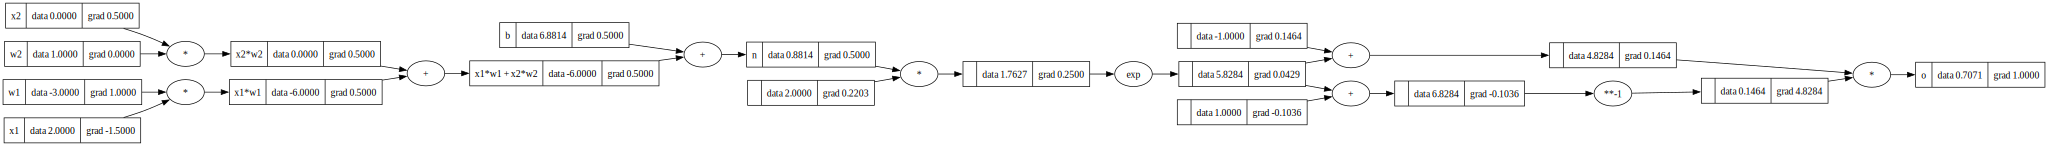

In [87]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [88]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [165]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        #return 0.0
        # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        # print(list(zip(self.w, x)))
        
    def parameters(self):
        return self.w + [self.b]
                
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # return outs
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        #params = []
        #for neuron in self.neurons:
        #    ps = neuron.parameters()
        #    params.extend(ps)
        #return params

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
            

In [246]:
#x = [2.0, 3.0]
#n = Neuron(2)
#n = Layer(2, 3)
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7266649083455778)

In [167]:
n.parameters()

[Value(data=0.5760554693520816),
 Value(data=-0.5221355024050094),
 Value(data=0.5100030299661298),
 Value(data=-0.8991393898926154),
 Value(data=0.7763999065756344),
 Value(data=0.10015141488700796),
 Value(data=0.8585723769279232),
 Value(data=0.6668067915807658),
 Value(data=0.4356110681776739),
 Value(data=0.7853100402616346),
 Value(data=0.3297610526436201),
 Value(data=0.17493480238647163),
 Value(data=-0.054540624643450775),
 Value(data=0.5641234950630045),
 Value(data=0.3650474518673661),
 Value(data=0.46206349114307743),
 Value(data=0.49290755273862197),
 Value(data=0.36175748755206927),
 Value(data=0.29260065189603646),
 Value(data=-0.4115764332543641),
 Value(data=0.6759651039168919),
 Value(data=-0.005119170416713947),
 Value(data=-0.15720333170773926),
 Value(data=0.19670407570159232),
 Value(data=0.8172393168726861),
 Value(data=0.05162580417395124),
 Value(data=0.26612657155838404),
 Value(data=-0.640126743855131),
 Value(data=0.05069562561476704),
 Value(data=0.95150276

In [168]:
len(n.parameters())

41

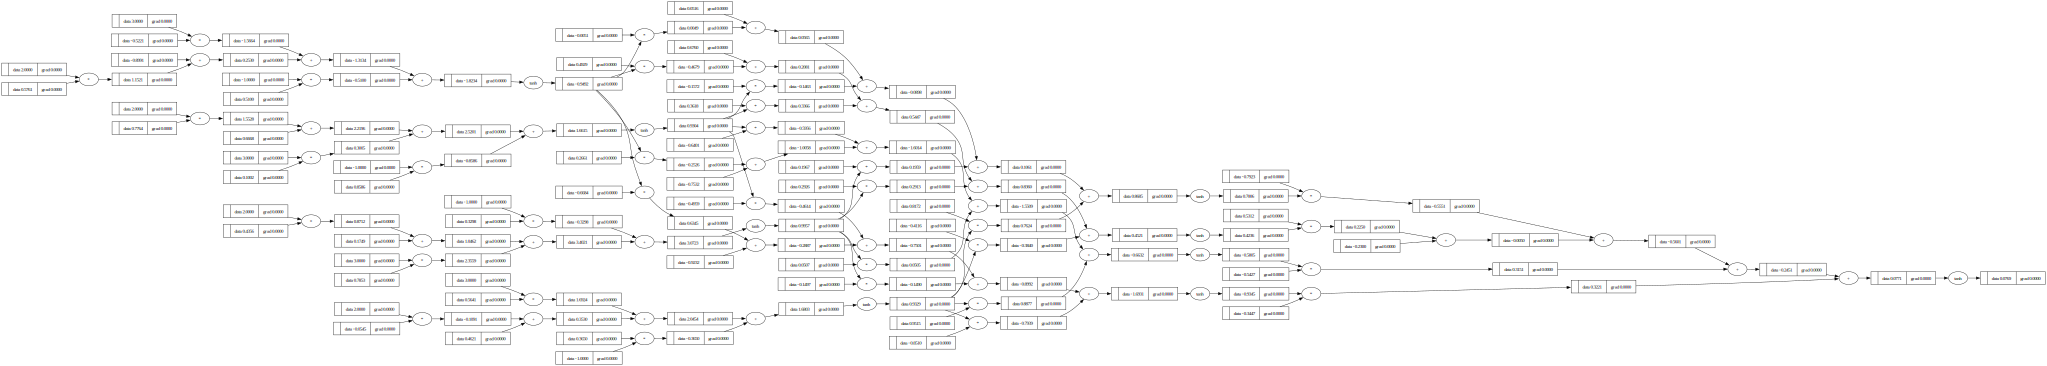

In [169]:
draw_dot(n(x))

In [247]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
#ypred = [n(x) for x in xs]
#ypred

In [266]:
for k in range (20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        #p.data += -0.01 * p.grad #too low of a learning rate
        #p.data += -0.1 * p.grad #too hight
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.0022870279297029514
1 0.0022763777547954375
2 0.0022658232503820564
3 0.0022553631498098523
4 0.002244996208521065
5 0.0022347212035757915
6 0.002224536933187041
7 0.0022144422162674944
8 0.0022044358919880843
9 0.0021945168193476102
10 0.002184683876753217
11 0.00217493596161164
12 0.0021652719899304153
13 0.002155690895929323
14 0.0021461916316613356
15 0.002136773166642995
16 0.0021274344874939854
17 0.0021181745975854165
18 0.0021089925166968533
19 0.0020998872806816792


In [265]:
#ypred = [n(x) for x in xs]
#loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
#loss

In [235]:
# n.layers[0].neurons[0].w[0].grad

In [236]:
# n.layers[0].neurons[0].w[0].data

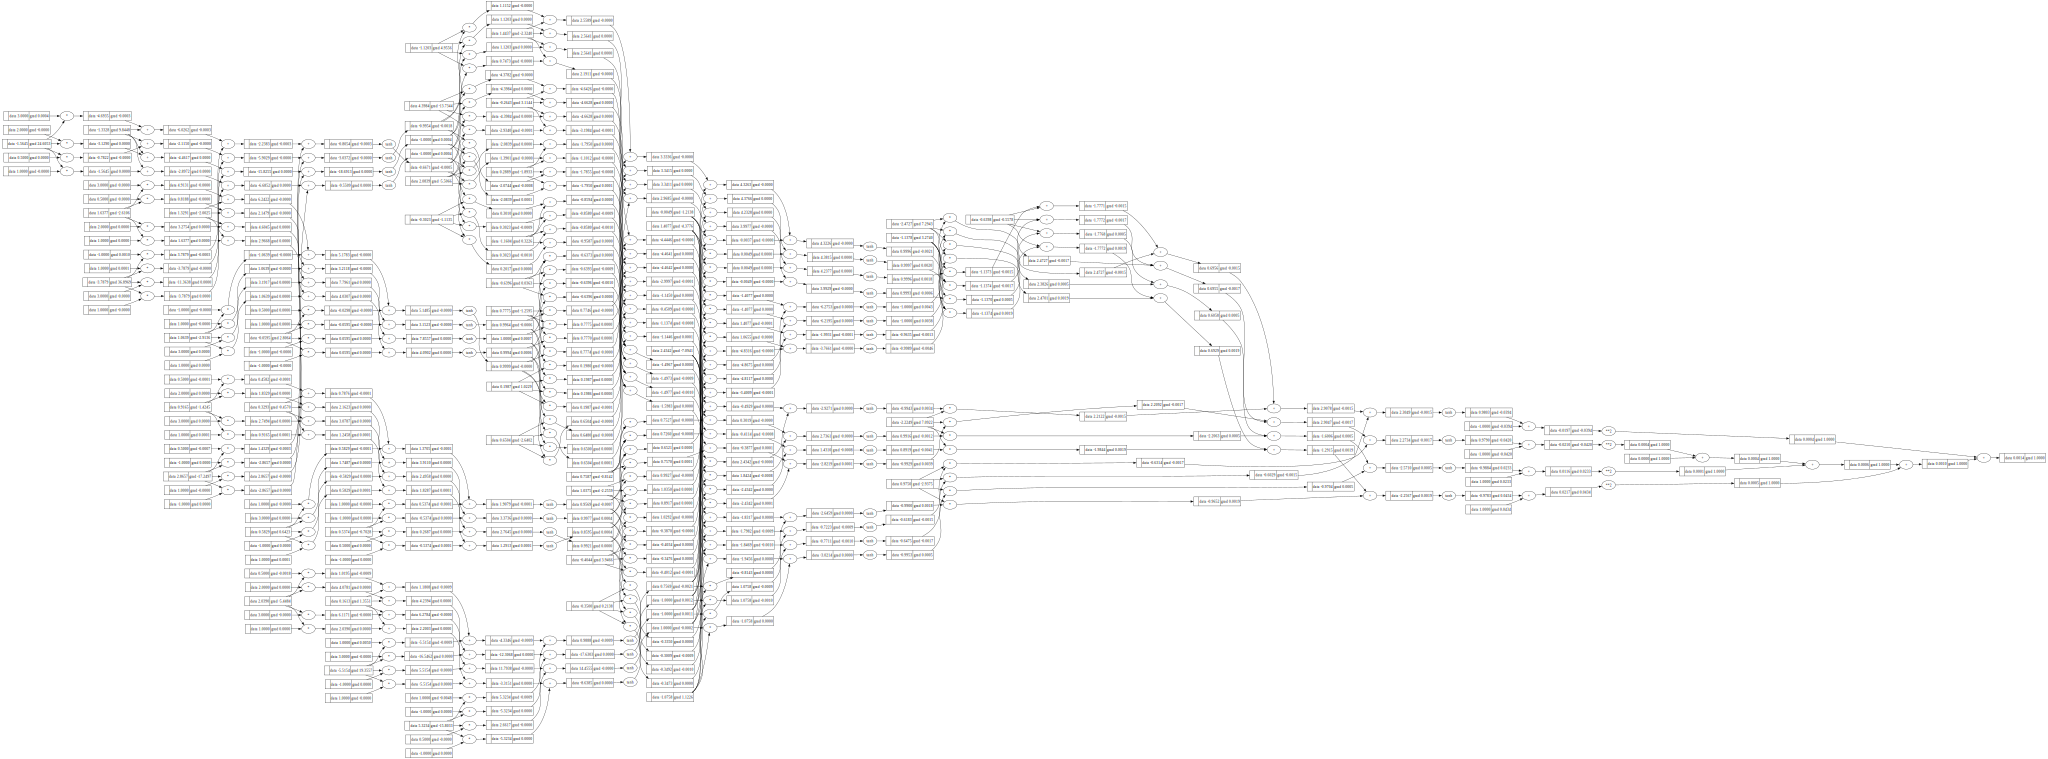

In [237]:
draw_dot(loss)

In [267]:
ypred

[Value(data=0.9835443770227512),
 Value(data=-0.9896601771571366),
 Value(data=-0.9678644564726805),
 Value(data=0.9737417696922608)]

In [242]:
n.parameters()

[Value(data=-4.025021379336824),
 Value(data=-7.477621056434911),
 Value(data=4.590695477463436),
 Value(data=-2.317234907597231),
 Value(data=1.898759150327401),
 Value(data=1.3552426945935006),
 Value(data=-0.3401784669111757),
 Value(data=1.5293294997201348),
 Value(data=1.0589080927214116),
 Value(data=0.5186663490255146),
 Value(data=0.6076685655968611),
 Value(data=0.3750406639771493),
 Value(data=2.5838779672748706),
 Value(data=-7.450971622938369),
 Value(data=6.903779969117568),
 Value(data=0.0257724183285879),
 Value(data=-1.615882991266039),
 Value(data=0.9034244216853138),
 Value(data=1.2630425698722816),
 Value(data=0.11648982383628965),
 Value(data=1.676149741642861),
 Value(data=5.771870236479251),
 Value(data=0.09640532869337116),
 Value(data=-0.7990406191083725),
 Value(data=1.845511449103407),
 Value(data=-0.5757705713338996),
 Value(data=2.6345840104730645),
 Value(data=0.9144331559783225),
 Value(data=0.8401539433670875),
 Value(data=3.1436311396893823),
 Value(data

In [176]:
# n.layers[0].neurons[0].w[0].data

0.5760554693520816

In [101]:
#topo = []
#visited = set()
#def build_topo(v):
#    if v not in visited:
#        visited.add(v)
#        for child in v._prev:
#            build_topo(child)
#    topo.append(v)
#build_topo(o)
#topo

In [102]:
#o.grad = 1.0

In [26]:
#o._backward()

In [27]:
#n._backward()

In [28]:
#b._backward()

In [29]:
#x1w1x2w2._backward()

In [30]:
#x2w2._backward()
#x1w1._backward()

In [31]:
#x1.grad = w1.data * x1w1.grad
#w1.grad = x1.data * x1w1.grad

In [32]:
#x2.grad = w2.data * x2w2.grad
#w2.grad = x2.data * x2w2.grad

In [33]:
#x1w1.grad = 0.5
#x2w2.grad = 0.5

In [34]:
#x1w1x2w2.grad = 0.5
#b.grad = 0.5

In [35]:
#n.grad = 0.5

In [36]:
#o.grad = 1.0

In [37]:
# o = tanh(n)
# do/dn = 1 - o**2
#1 - o.data**2

In [38]:
#a = Value(3.0, label='a')
#b = a + a; b.label = 'b'
#b.backward()
#draw_dot(b)

In [39]:
#a = Value(-2.0, label='a')
#a = Value(3.0, label='b')
#d = a * b; d.label = 'd'
#e = a + b; e.label = 'e'
#f = d * e; f.label = 'f'

#f.backward()

#draw_dot(f)